In [122]:
import xarray as xr
import xsimlab as xs
import zarr
import numpy as np
from dask.diagnostics import Profiler, ResourceProfiler, CacheProfiler, ProgressBar
from time import sleep
import pandas as pd
from collections.abc import Iterable
import itertools

# 20201007_try_xarray_simlab
----

Continuation of [20201005_try_xarray_simlab](20201005_try_xarray_simlab.ipynb). Recap of progress is below:

In [4]:
# Process definitions

COUNTS_DIMS = ('age_group', 'risk_group', 'compartment', 'vertex')

@xs.process
class DefineCoords:
    """Example process that generates coordinates for each dimension in the counts array (except time).
    """
    
    age_group = xs.index(dims='age_group')
    risk_group = xs.index(dims='risk_group')
    compartment = xs.index(dims='compartment')
    vertex = xs.index(dims='vertex')
        
    def initialize(self):
        """
        """
        self.age_group = ['0-4', '5-17', '18-49', '50-64', '65+']
        self.risk_group = ['low', 'high']
        self.compartment = ['S', 'E', 'I', 'R']
        self.vertex = range(4)

    
@xs.process
class ToySEIR:
    
    # current counts
    delta_counts = xs.group('delta_counts')
    counts = xs.variable(
        dims=COUNTS_DIMS,
        encoding=dict(
            # `chunks` is not read here
            # chunks=[None, 1, None, 4],
            dtype='int32'
        ),
        intent='inout')
        
    def run_step(self):
        """
        """
        # print(f"running ToySEIR.run_step")
        
        # Calculate the net change in counts for this timestep
        self._delta_sum = sum((v for v in self.delta_counts))
    
    def finalize_step(self):
        # Apply all deltas calculated during this timestep
        self.counts += self._delta_sum
        
       
@xs.process
class VxSpecific:
    """Example of a process that modifies `count` based on
    the value of the `vertex` coordinate.
    """
    
    counts = xs.foreign(ToySEIR, 'counts', intent='in')
    vx_tensor = xs.variable(groups=['delta_counts'], intent='out')
    
    # In case we need timestep information
    # @xs.runtime(args='step')
    def run_step(self):
        vx_coords = self.counts.coords['vertex'].copy()
        self.vx_tensor = vx_coords
    
@xs.process
class ToyDelta:
    """Example process that defines a static scalar
    in the `delta_counts` group.
    """
    
    scalar = xs.variable(groups=['delta_counts'], intent='out', static=True)
    transmission = xs.variable(dims=COUNTS_DIMS, groups=['delta_counts'], intent='out', static=True)
    counts = xs.foreign(ToySEIR, 'counts', intent='in')
    
    def initialize(self):
        self.scalar = 0
        self.transmission = xr.zeros_like(self.counts)
        
        
@xs.process
class InitCounts:
    """Example process that initializes the current counts array
    of zeros based on input coordinates.
    """
    
    counts = xs.foreign(ToySEIR, 'counts', intent='out')
    age_group = xs.foreign(DefineCoords, 'age_group')
    risk_group = xs.foreign(DefineCoords, 'risk_group')
    compartment = xs.foreign(DefineCoords, 'compartment')
    vertex = xs.foreign(DefineCoords, 'vertex')
    
    def initialize(self):
        self.counts = xr.DataArray(
            data=0,
            dims=COUNTS_DIMS,
            coords={
                'age_group': self.age_group,
                'risk_group': self.risk_group,
                'compartment': self.compartment,
                'vertex': self.vertex
            }
        )

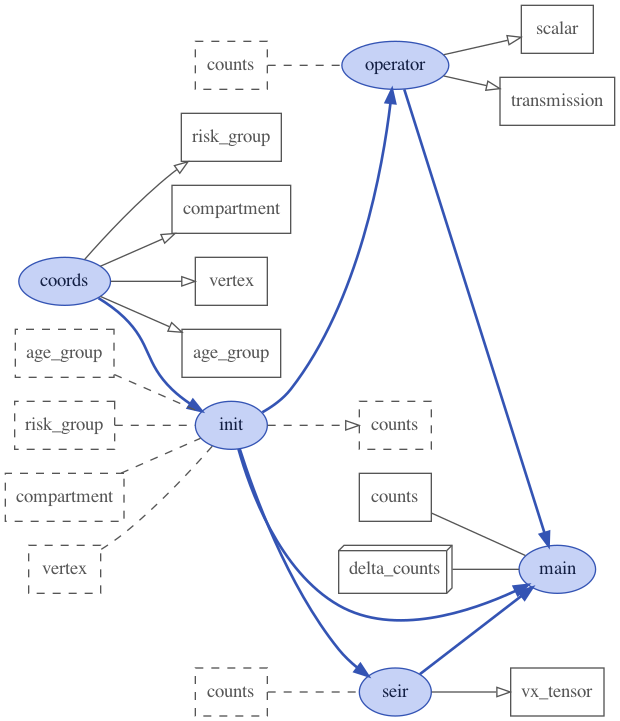

In [5]:
# Model definition
toy_seir = xs.Model(dict(
    init=InitCounts,
    main=ToySEIR,
    operator=ToyDelta,
    seir=VxSpecific,
    coords=DefineCoords
))
toy_seir.visualize(show_inputs=True, show_variables=True)

In [6]:
# Run the model
in_ds = xs.create_setup(
    model=toy_seir,
    clocks={
        'step': range(20)
    },
    input_vars={},
    output_vars={
        'main__counts': 'step',
    }
)

# How to pass chunks to zarr
encoding=dict(
    main__counts=dict(
        # No chunks for `step` and `risk_group`
        # chunks=[None, 1, None, 4],
        # Chunks for `step` only
        chunks=[None, None, None, None, 4],
        dtype='int64'
    )
)

# Track progress with Dask profilers
with Profiler() as prof:
# with ResourceProfiler(dt=0.25) as prof:
    out_ds = in_ds.xsimlab.run(
        model=toy_seir,
        parallel=True,
        # parallel=False,
        scheduler='threads',
        # must pass `store` kwarg to use zarr backend
        store=zarr.TempStore(),
        encoding=encoding
    )
prof.visualize(show=True, save=False)
out_ds

<xarray.Dataset>
Dimensions:       (age_group: 5, compartment: 4, risk_group: 2, step: 20, vertex: 4)
Coordinates:
  * age_group     (age_group) <U5 '0-4' '5-17' '18-49' '50-64' '65+'
  * compartment   (compartment) <U1 'S' 'E' 'I' 'R'
  * risk_group    (risk_group) <U4 'low' 'high'
  * step          (step) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19
  * vertex        (vertex) int64 0 1 2 3
Data variables:
    main__counts  (step, age_group, risk_group, compartment, vertex) int64 dask.array<chunksize=(20, 5, 2, 4, 4), meta=np.ndarray>

# Symmetrical Arrays

There are two notable symmetrical arrays that will likely be used in this model: a mixing (phi) matrix, and an adjacency (edge weight) matrix. Each matrix describes the weights of edges in some graph, where vertices are groups of individuals in a particular category. This category is represented as some identifier that corresponds to a unique combination of dimensions: age, risk, census tract, etc.

In short, I want to know whether `xarray.Datasets` and `xarray-simlab` can support this type of data, and if so, how it accomplishes this. In SEIRcity v2, we get this type of structure using `MultiIndex` in `xarray`, which is leveraged by the `MidxAccessor` class. Could `xarray-simlab` support this type of data structure, and would it be compatible with zarr (I know for a fact that MultiIndex is not compatible with NetCDF)?

To answer these questions, let's set up another toy model:

In [7]:
from numcodecs import MsgPack, Pickle

In [8]:
def get_pd_midx(dims, coords, suffix):
    """
    """
    assert isinstance(dims, list)
    assert isinstance(coords, dict)
    assert isinstance(suffix, str)
    # midx_dims = ['age_group', 'risk_group']
    # midx_coords = dict(age_group=self.age_group, risk_group=self.risk_group)
    
    coords_as_lst = [list(coords[d]) for d in dims]
    return pd.MultiIndex.from_product(
        coords_as_lst, names=[f"{d}{suffix}" for d in dims]
    )

In [11]:
@xs.process
class MidxSetter:
    
    age_group = xs.index(dims='age_group')
    risk_group = xs.index(dims='risk_group')
    midx1 = xs.index(
        dims=('age_group', 'risk_group'),
        encoding=dict(
            # dtype='object',
            object_codec=MsgPack()
        )
    )
    
    def initialize(self):
        self.age_group = ['0-4', '5-17', '18-49', '50-64', '65+']
        self.risk_group = ['low', 'high']  
        
        # Sets as a data variable
        midx_da = xr.DataArray(
            0,
            dims=('age_group', 'risk_group'),
            coords=dict(age_group=self.age_group, risk_group=self.risk_group)
        )
        
        # 
        midx_pd = get_pd_midx(
            dims=['age_group', 'risk_group'],
            coords=dict(age_group=self.age_group, risk_group=self.risk_group),
            suffix='_1'
        )
        print(midx_pd)
        
        self.midx1 = midx_pd

In [12]:
# Model definition
toy_midx = xs.Model(dict(
    midx_setter=MidxSetter,
))

in_ds = xs.create_setup(
    model=toy_midx,
    clocks={
        'step': range(10)
    },
    input_vars={},
    output_vars={
#         'c__var_c': 'step'
    }
)

# How to pass chunks to zarr
encoding=dict(
    midx_setter__age_group=dict(
        dtype='str'
    )
)

# Track progress with Dask profilers
with Profiler() as prof:
# with ResourceProfiler(dt=0.25) as prof:
    out_ds = in_ds.xsimlab.run(
        model=toy_midx,
        # parallel=True,
        parallel=False,
        # scheduler='threads',
        # store=zarr.TempStore(),
        encoding=encoding
    )
prof.visualize(show=False, save=False)
out_ds

MultiIndex([(  '0-4',  'low'),
            (  '0-4', 'high'),
            ( '5-17',  'low'),
            ( '5-17', 'high'),
            ('18-49',  'low'),
            ('18-49', 'high'),
            ('50-64',  'low'),
            ('50-64', 'high'),
            (  '65+',  'low'),
            (  '65+', 'high')],
           names=['age_group_1', 'risk_group_1'])


ValueError: missing object_codec for object array

So we get a ValueError from zarr here for using a MultiIndex. Let's see if this is an incompatibility, or just an issue of improper usage. I'll try writing a simple DataArray to zarr...

In [13]:
dims = ['x', 'y']
coords = dict(x=range(3), y=range(2))
midx_1 = get_pd_midx(dims=dims, coords=coords, suffix='_1')
midx_2 = get_pd_midx(dims=dims, coords=coords, suffix='_2')

In [14]:
da = xr.DataArray(
    0, dims=['midx_1', 'midx_2'], coords=dict(
        midx_1=midx_1,
        midx_2=midx_2
    )
)#.reset_index(['midx_1', 'midx_2'])
ds = xr.Dataset(dict(value=da))
ds

<xarray.Dataset>
Dimensions:  (midx_1: 6, midx_2: 6)
Coordinates:
  * midx_1   (midx_1) MultiIndex
  - x_1      (midx_1) int64 0 0 1 1 2 2
  - y_1      (midx_1) int64 0 1 0 1 0 1
  * midx_2   (midx_2) MultiIndex
  - x_2      (midx_2) int64 0 0 1 1 2 2
  - y_2      (midx_2) int64 0 1 0 1 0 1
Data variables:
    value    (midx_1, midx_2) int64 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0

In [15]:
ds.to_zarr(zarr.TempStore())

NotImplementedError: variable None is a MultiIndex, which cannot yet be serialized to netCDF files (https://github.com/pydata/xarray/issues/1077). Use reset_index() to convert MultiIndex levels into coordinate variables instead.

It seems that the incompatiblity between zarr and MultiIndex goes back to the NetCDF4-MultiIndex incompatibility.

The [xarray GitHub Issues](https://github.com/pydata/xarray/issues/1077) had some helpful workarounds that involve encoding a MultiIndex, with the help of `np.ravel_multi_index`:

In [41]:
import numpy as np
import pandas as pd
import xarray as xr


def encode_multiindex(ds, idxname):
    encoded = ds.reset_index(idxname)
    coords = dict(zip(ds.indexes[idxname].names, ds.indexes[idxname].levels))
    for coord in coords:
        encoded[coord] = coords[coord].values
    shape = [encoded.sizes[coord] for coord in coords]
    encoded[idxname] = np.ravel_multi_index(ds.indexes[idxname].codes, shape)
    print(f"shape: {shape}")
    encoded[idxname].attrs["compress"] = " ".join(ds.indexes[idxname].names)
    return encoded


def decode_to_multiindex(encoded, idxname):
    names = encoded[idxname].attrs["compress"].split(" ")
    shape = [encoded.sizes[dim] for dim in names]
    indices = np.unravel_index(encoded.landpoint.values, shape)
    arrays = [encoded[dim].values[index] for dim, index in zip(names, indices)]
    mindex = pd.MultiIndex.from_arrays(arrays)

    decoded = xr.Dataset({}, {idxname: mindex})
    for varname in encoded.data_vars:
        if idxname in encoded[varname].dims:
            decoded[varname] = (idxname, encoded[varname].values)
    return decoded


ds1 = xr.Dataset(
    {"landsoilt": ("landpoint", np.random.randn(4))},
    {
        "landpoint": pd.MultiIndex.from_product(
            [["a", "b"], [1, 2]], names=("lat", "lon")
        )
    },
)

ds2 = xr.Dataset(
    {"landsoilt": ("landpoint", np.random.randn(4))},
    {
        "landpoint": pd.MultiIndex.from_arrays(
            [["a", "b", "c", "d"], [1, 2, 4, 10]], names=("lat", "lon")
        )
    },
)

ds3 = xr.Dataset(
    {"landsoilt": ("landpoint", np.random.randn(4))},
    {
        "landpoint": pd.MultiIndex.from_arrays(
            [["a", "b", "b", "a"], [1, 2, 1, 2]], names=("lat", "lon")
        )
    },
)


idxname = "landpoint"
for dataset in [ds1, ds2, ds3]:
    xr.testing.assert_identical(
        decode_to_multiindex(encode_multiindex(dataset, idxname), idxname), dataset
    )

shape: [2, 2]
shape: [4, 4]
shape: [2, 2]


In [42]:
encode_multiindex(ds3, idxname)

shape: [2, 2]


<xarray.Dataset>
Dimensions:    (landpoint: 4, lat: 2, lon: 2)
Coordinates:
  * lat        (lat) object 'a' 'b'
  * lon        (lon) int64 1 2
  * landpoint  (landpoint) int64 0 3 2 1
Data variables:
    landsoilt  (landpoint) float64 0.3346 1.445 0.04113 0.6588

Seems to work well. Recipe for decoding is given `attr` dictionary for the coordinate that is encoded as a MultiIndex (`landpoint` in this case).

Let's sketch out how to only create an encoded index:

In [63]:
# Setup args/kwargs
c = dict(
    ag=np.array(['0-4', '5-17', '18-49', '50-64', '65+']),
    rg=np.array(['low', 'high'])
)
shape = [len(c['ag']), len(c['rg'])]
names = c.keys()

# Encoding
midx = pd.MultiIndex.from_product(c.values(), names=names)
encoded_coord = np.ravel_multi_index(midx.codes, shape)

# Decoding
indices = np.unravel_index(encoded_coord, shape)
arrays = [c[dim][index] for dim, index in zip(names, indices)]
decoded_midx = pd.MultiIndex.from_arrays(arrays)
decoded_midx

MultiIndex([(  '0-4', 'high'),
            (  '0-4',  'low'),
            ('18-49', 'high'),
            ('18-49',  'low'),
            ( '5-17', 'high'),
            ( '5-17',  'low'),
            ('50-64', 'high'),
            ('50-64',  'low'),
            (  '65+', 'high'),
            (  '65+',  'low')],
           )

This is a viable option that (I believe) would support sparse MultiIndices. The alternative is to encode `pd.MultiIndex.from_product` in the encoded coordinate. This might be less computationally intensive to encode/decode. Let's forge ahead with the above implementation, and see if the `xarray-simlab` workflow would be able to read/write using this coordinate system.

We start by generalizing the above workflow in functions:

In [91]:
def get_encoded_midx(coords):
    """TODO: pass dims so we dont rely on coords.keys() order
    """
    # Type checking
    assert isinstance(coords, dict)
    c = coords.copy()
    for k, v in c.items():
        # Since we're using the `size` attr...
        if isinstance(v, np.ndarray):
            pass
        elif isinstance(v, Iterable):
            c[k] = np.array(v)
        else:
            raise TypeError()
        
    # Generate pandas MultiIndex
    shape = [_c.size for _c in c.values()]
    midx = pd.MultiIndex.from_product(c.values(), names=c.keys())
    return np.ravel_multi_index(midx.codes, shape)

encoded_midx = get_encoded_midx(dict(
    ag=np.array(['0-4', '5-17', '18-49', '50-64', '65+']),
    rg=np.array(['low', 'high'])
))
encoded_midx

array([1, 0, 5, 4, 3, 2, 7, 6, 9, 8])

In [172]:
def ravel_encoded_midx(midx, coords):
    """TODO: pass dims so we dont rely on coords.keys() order
    """
    # Type checking
    assert isinstance(midx, np.ndarray)
    assert isinstance(coords, dict)
    c = coords.copy()
    for k, v in c.items():
        # Since we're using the `size` attr...
        if isinstance(v, np.ndarray):
            pass
        elif isinstance(v, Iterable):
            c[k] = np.array(v)
        else:
            raise TypeError()
        
    # Decode to a MultiIndex
    shape = [_c.size for _c in c.values()]
    indices = np.unravel_index(encoded_coord, shape)
    arrays = [c[dim][index] for dim, index in zip(c.keys(), indices)]
    return pd.MultiIndex.from_arrays(arrays)

decoded_midx = ravel_encoded_midx(
    midx=encoded_midx,
    coords=dict(
        ag=np.array(['0-4', '5-17', '18-49', '50-64', '65+']),
        rg=np.array(['low', 'high'])
    )
)
decoded_midx

MultiIndex([(  '0-4', 'high'),
            (  '0-4',  'low'),
            ('18-49', 'high'),
            ('18-49',  'low'),
            ( '5-17', 'high'),
            ( '5-17',  'low'),
            ('50-64', 'high'),
            ('50-64',  'low'),
            (  '65+', 'high'),
            (  '65+',  'low')],
           )

Let's try implementing these methods in the toy `MidxSetter` process:

It would be nice if there were some staic mapping from tuple indices to the corresponding integer index in the `midx1` and `midx2` coordinates. I suppose this would take the form of a new data variable `midx_mapping` that has `midx1` and `midx2` dims. Less memory efficient obviously (effectively only by one additional timepoint on the phi array), but removes requirement of constructing the MultiIndex instance every step.

In [204]:
@xs.process
class MidxSetter:
    """TODO: handle the coords dynamically as a `group`
    """
    
    age_group = xs.index(dims='age_group')
    risk_group = xs.index(dims='risk_group')
    midx1 = xs.index(dims=('midx1'))
    midx2 = xs.index(dims=('midx2'))
    midx_mapping = xs.variable(dims=('age_group', 'risk_group'), static=True, intent='out')
    
    def initialize(self):
        self.age_group = ['0-4', '5-17', '18-49', '50-64', '65+']
        self.risk_group = ['low', 'high']  
        encoded_midx = get_encoded_midx(coords=dict(age_group=self.age_group, risk_group=self.risk_group))
        self.midx1 = encoded_midx
        self.midx2 = encoded_midx
        
        self.midx_mapping = self._get_midx_mapping()
        
    def _get_midx_mapping(self):
        shape = [len(self.age_group), len(self.risk_group)]
        coords = dict(
            age_group=self.age_group,
            risk_group=self.risk_group
        )
        da = xr.DataArray(
            data=self.midx1.reshape(shape),
            dims=('age_group', 'risk_group'),
            coords=dict(
                age_group=self.age_group,
                risk_group=self.risk_group
            )
        )
        return da
        
@xs.process
class ToyPhi:
    """
    """
    
    midx1 = xs.foreign(MidxSetter, 'midx1', intent='in')
    midx2 = xs.foreign(MidxSetter, 'midx2', intent='in')
    midx_mapping = xs.foreign(MidxSetter, 'midx_mapping', intent='in')
    age_group = xs.foreign(MidxSetter, 'age_group', intent='in')
    risk_group = xs.foreign(MidxSetter, 'risk_group', intent='in')
    phi = xs.variable(
        dims=('midx1', 'midx2'),
        # dims='midx1',
        intent='out')
    
    def initialize(self):
        self.phi = np.zeros(shape=[self.midx1.size, self.midx2.size], dtype='int32')
        
    def finalize_step(self):
        """Toy behavior of how the SEIR model would access this array
        
        TODO: a version of this with matrix multiplication
        """
        
        # Iterate over every pair of age-risk pairs
        for a1, r1, a2, r2 in itertools.product(*[self.age_group, self.risk_group] * 2):
            # print(combo)
            
            # Get the indices in midx1/midx2
            i = self.midx_mapping.loc[(a1, r1)].values
            j = self.midx_mapping.loc[(a2, r2)].values
            # print(i, j)
            
            # ...then index the symmetrical array using
            # the derived i j indices
            self.phi[i, j] += 1
        
        # Validate that this encoded index actually works
        # print(self._validate_midx())
    
    def _validate_midx(self):
        # Validate that this is actually the correct index in midx1
        return ravel_encoded_midx(
            midx=self.midx1,
            coords=dict(
                age_group=self.age_group,
                risk_group=self.risk_group
            )
        )

In [208]:
# Model definition
toy_midx = xs.Model(dict(
    midx_setter=MidxSetter,
    phi=ToyPhi
))

in_ds = xs.create_setup(
    model=toy_midx,
    clocks={
        'step': range(70)
    },
    input_vars={},
    output_vars={
        'phi__phi': 'step',
        'midx_setter__midx_mapping': 'step'
    }
)

# Track progress with Dask profilers
# with Profiler() as prof:
with ResourceProfiler(dt=0.25) as prof:
    out_ds = in_ds.xsimlab.run(
        model=toy_midx,
        # parallel=True,
        parallel=False,
        # scheduler='threads',
        # store=zarr.TempStore()
    )
    out_ds.load()
    sleep(5)
prof.visualize(show=True, save=False)
out_ds

<xarray.Dataset>
Dimensions:                    (age_group: 5, midx1: 10, midx2: 10, risk_group: 2, step: 70)
Coordinates:
  * age_group                  (age_group) <U5 '0-4' '5-17' ... '50-64' '65+'
  * midx1                      (midx1) int64 1 0 5 4 3 2 7 6 9 8
  * midx2                      (midx2) int64 1 0 5 4 3 2 7 6 9 8
  * risk_group                 (risk_group) <U4 'low' 'high'
  * step                       (step) int64 0 1 2 3 4 5 6 ... 64 65 66 67 68 69
Data variables:
    midx_setter__midx_mapping  (step, age_group, risk_group) int64 1 0 5 ... 9 8
    phi__phi                   (step, midx1, midx2) int32 0 0 0 0 ... 69 69 69

In [138]:
out_ds.midx_setter__midx_mapping.loc[dict(step=0)]

<xarray.DataArray 'midx_setter__midx_mapping' (age_group: 5, risk_group: 2)>
array([[1, 0],
       [5, 4],
       [3, 2],
       [7, 6],
       [9, 8]])
Coordinates:
  * age_group   (age_group) <U5 '0-4' '5-17' '18-49' '50-64' '65+'
  * risk_group  (risk_group) <U4 'low' 'high'
    step        int64 0
Attributes:
    _FillValue:  0

This encoded index appears to be working well. Only thing is that the `ravel_endoced_midx` and `get_encoded_midx` functions rely on `coords.keys()` to get an ordered list of dims. I'm actually not sure if this would make a difference (as long as `coords.values()` is in the same order), definitely not for this toy implementation, but it's an easy enough fix and is worth the added consistency.

Another important consideration is how this framework will handle sparse or recurring values on the `time`/`step` axis. This is important for things like:
* Varying phi based on school calendar
* Varying adjacency matrix based on day of the week, recurring every week
* Switching on/off "stochastic mode" at a given timepoint
    * Does this even need it's own data variable?
    * ~~Perhaps one could just use `@xs.runtime(args='step')` wrapping a function with `if step == config.start_deterministic`...~~
    * Probably best to just give the data variable `deterministic` its own clock.
    
In any case, `xarray-simlab` provides the concept of multiple clocks. One could, for instance, have a different clock that corresponds to each of these events. ~~This is probably at best equivalently clunky to defining the above properties at all points on the time axis.~~ Actually, no. Each one of these clocks could be dynamically shaped (could have only a few timepoints), and would apply to only one of the data variables. I'm still thinking in terms of arrays, not Datasets. So it's quite viable to have separate clocks for the `counts`, `phi`, and `adjacency_weight` arrays, as well as the arrays for every other epidemiological parameter.

Now that I mention epidemiological parameters:
* A lot of the epidemiological params in SEIRcity v1 and v2 are simply multipliers on the value `phi`. These **could** be safely deprecated, I think. The benefit to keeping them is that you get near optimal memory efficiency if you want to vary phi only on one axis. The downside to keeping all these variables is that this multiplication-on-a-single-axis operation will be hard-coded in the simulation engine.

# A leap of faith

It seems that `xarray-simlab` has met or surpassed my expectations with regards to its usefulness for this project. It allows for streamlined, reproducible model development with a minimal boilerplate. Importantly, it natively supports the software stack that I wanted to introduce: `xarray.Dataset`, Dask, and Zarr/NetCDF.